## Import Necessary Libraries & Loading data

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("C:\ALL FROM ONE DRIVE\Desktop\data11\Flight_delay.csv")
df.head(2)

,DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,4,03-01-2019,1829,1959,1925,WN,Southwest Airlines Co.,3920,N464WN,90,...,3,10,0,N,0,2,0,0,0,32
1,4,03-01-2019,1937,2037,1940,WN,Southwest Airlines Co.,509,N763SW,240,...,3,7,0,N,0,10,0,0,0,47


In [2]:
#Selecting varables of interest
df = df[['DayOfWeek','Date','DepTime','Airline','Origin','Dest','CarrierDelay']]
df.head(2)

,DayOfWeek,Date,DepTime,Airline,Origin,Dest,CarrierDelay
0,4,03-01-2019,1829,Southwest Airlines Co.,IND,BWI,2
1,4,03-01-2019,1937,Southwest Airlines Co.,IND,LAS,10


## Data Preprocessing and Model Preparation

In [3]:
#Identifying missing values
df.isnull().sum(),
#Data types
df.dtypes

DayOfWeek        int64
Date            object
DepTime          int64
Airline         object
Origin          object
Dest            object
CarrierDelay     int64
dtype: object

In [4]:
# Change Date to pandas datetime & create month date variables
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [5]:
# Since XGBoost doesn't handle datetime types, Drop date
df = df.drop(columns=['Date'])

In [6]:
# Identify the categorical features
categories = df.select_dtypes(include=['object']).columns
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

In [7]:
#Creating Dummy Variables (One-Hot Encoding) for Categorical Data.
df_encoded = pd.get_dummies(df, drop_first=True)

In [8]:
# Prepare the target variable(s) for analysis.
df_encoded['is_delayed_50+'] = np.where(df_encoded['CarrierDelay'] > 50, 1, 0)


In [9]:
# Define the independent variables (features) and the dependent variable (target).
X = df_encoded.drop(columns=['is_delayed_50+', 'CarrierDelay'])
y = df_encoded['is_delayed_50+']

In [10]:
# Partition the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

C:\Users\Yasir09\AppData\Local\Temp\ipykernel_18732\633922321.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  y_train.value_counts().plot(kind='pie', autopct='%1.1f%%').figure.show()


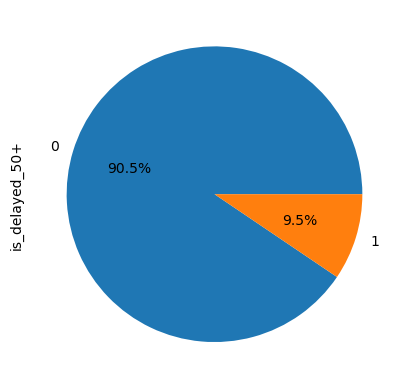

In [11]:
# Display the data imbalances
y_train.value_counts().plot(kind='pie', autopct='%1.1f%%').figure.show()

In [12]:
from imblearn.over_sampling import SMOTE

# Assuming X_train and y_train are your features and labels
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

C:\Users\Yasir09\AppData\Local\Temp\ipykernel_18732\764532100.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  y_resampled.value_counts().plot(kind='pie', autopct='%1.1f%%').figure.show()


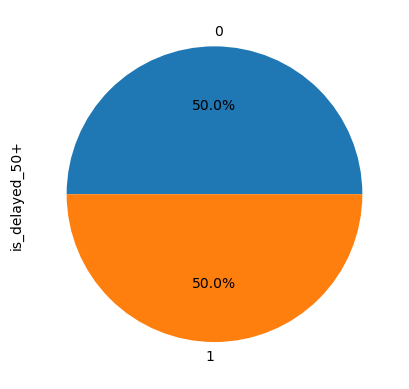

In [13]:
# Handling data imbalances by using SMOTE
y_resampled.value_counts().plot(kind='pie', autopct='%1.1f%%').figure.show()

## Exploratory Data Analysis

In [14]:
# Combine X_resampled and y_resampled together
train_set = pd.concat([X_resampled, y_resampled], axis= 1)

In [15]:
# reversing one-hot encoding is to restore the original categorical variable
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

In [16]:
# Reversing one-hot encoding for multiple categorical variables.
for category in categories:
    one_hot_columns = [col for col in train_set.columns if col.startswith(f'{category}_')]
    train_set[category] = train_set[one_hot_columns].idxmax(axis=1)
    train_set = train_set.drop(columns=one_hot_columns)
    train_set[category] = train_set[category].str.replace(f'{category}_', '')

In [17]:
train_set


,DayOfWeek,DepTime,month,day,is_delayed_50+,Airline,Origin,Dest
0,5,2124,2,22,0,US Airways Inc.,PHX,LAS
1,4,2218,6,19,0,American Airlines Inc.,DFW,OAK
2,6,1500,4,26,1,American Airlines Inc.,ORD,MIA
3,3,2112,3,12,1,American Airlines Inc.,JNU,SEA
4,6,1730,1,26,0,American Airlines Inc.,SJU,ORD
...,...,...,...,...,...,...,...,...
614185,2,810,2,12,1,American Airlines Inc.,ABI,ABI
614186,6,952,6,28,1,American Airlines Inc.,ABI,ABI
614187,7,2002,2,17,1,American Airlines Inc.,ABI,ABI
614188,5,1738,6,27,1,American Eagle Airlines Inc.,ABI,ABI


In [18]:
#Examine the distribution of the target variable
train_set['is_delayed_50+'].value_counts()


0    307095
1    307095
Name: is_delayed_50+, dtype: int64

In [19]:
train_set['is_delayed_50+'].mean()

0.5

<Axes: title={'center': 'Delayed Flights (50+ min) by Airline'}, ylabel='is_delayed_50+'>

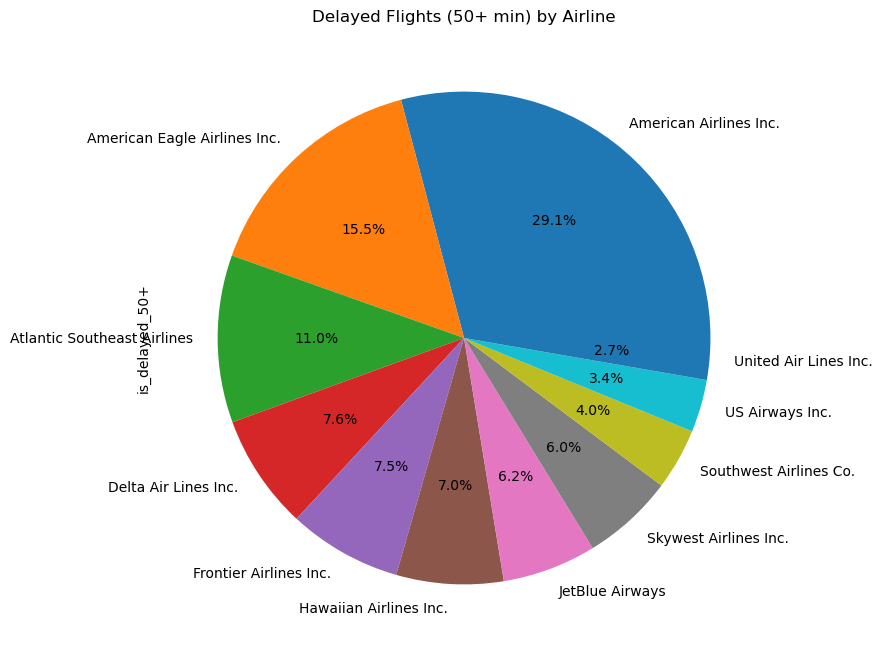

In [69]:
# Delays categorized by airline

train_set.groupby('Airline')['is_delayed_50+'].mean().mul(100).round(3).sort_values(ascending=False).plot(kind='pie', figsize=(8, 8), autopct='%1.1f%%', labels=train_set.groupby('Airline').size().index, title='Delayed Flights (50+ min) by Airline', legend=False)


In [62]:
# Delays categorized by Days of the Week
DayOfWeek_pct_delayed = train_set.groupby('DayOfWeek')['is_delayed_50+'].mean().round(3)*100
DayOfWeek_pct_delayed


#DayOfWeek_pct_delayed = train_set.groupby('DayOfWeek')['is_delayed_50+'].mean().round(3)*100
#DayOfWeek_pct_delayed.plot(kind='bar', figsize=(10, 6), color='skyblue', title='Percentage of Delayed Flights (50+ min) by Day of Week', xlabel='Day of Week', ylabel='Delay Percentage (%)', rot=0)


DayOfWeek
1    53.5
2    51.2
3    51.9
4    49.6
5    48.3
6    58.8
7    34.0
Name: is_delayed_50+, dtype: float64

<Axes: title={'center': 'Top 10 Origins by Delay Percentage (50+ min)'}, xlabel='Origin', ylabel='Delay Percentage (%)'>

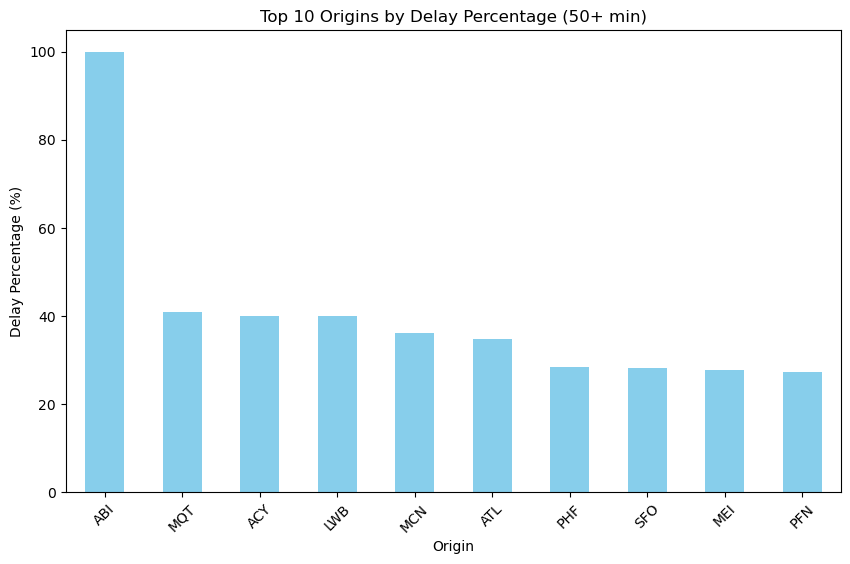

In [83]:
# Delays categorized by Origin Airport

#pct_delay_by_origin = train_set.groupby('Origin')['is_delayed_50+'].mean().sort_values(ascending=False).round(3)*100
#pct_delay_by_origin.head(10)

#pct_delay_by_origin = train_set.groupby('Origin')['is_delayed_50+'].mean().sort_values(ascending=False).round(3)*100

pct_delay_by_origin.head(10).plot(kind='bar', figsize=(10, 6), color='skyblue', title='Top 10 Origins by Delay Percentage (50+ min)', xlabel='Origin', ylabel='Delay Percentage (%)', rot=45)


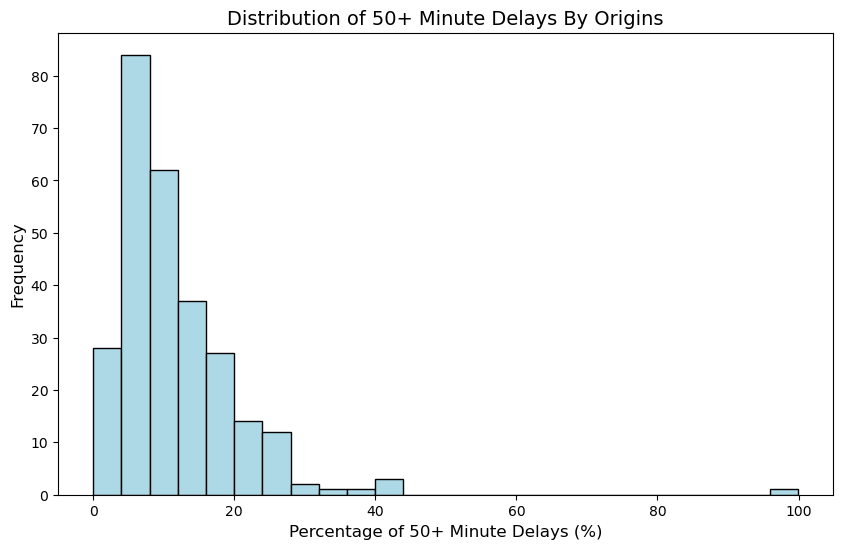

In [23]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pct_delay_by_origin.values, bins=25, color='lightblue', edgecolor='black')

# Add labels and title
plt.title("Distribution of 50+ Minute Delays By Origins", fontsize=14)
plt.xlabel("Percentage of 50+ Minute Delays (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show the plot
plt.show()

## Model training and Evaluation

In [24]:
# Train and initialize the XGBoost classifier (baseline model).

xgb_model = xgb.XGBClassifier(random_state=0, eval_metric='logloss')
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

In [25]:
# Train the model
xgb_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

In [26]:
# Make predictions on the test set

y_pred = xgb_model.predict(X_test)

In [27]:
#Evalate performance of the model
print("XGBoost Classifier (Baseline):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

XGBoost Classifier (Baseline):
Accuracy: 0.8962


In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[129167,   2293],
       [ 12791,   1115]], dtype=int64)

In [29]:
# Predict probabilities for the test set (to calculate AUC)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # We need probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.6726


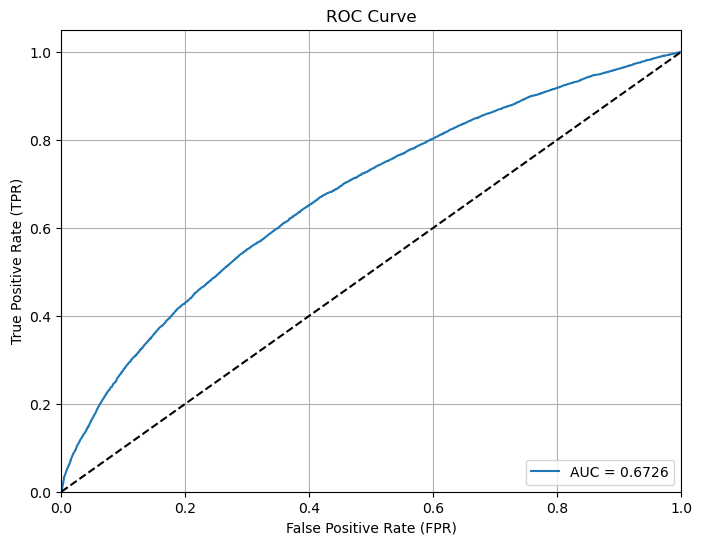

In [30]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Do Cross-Validated Grid Search


Using a reduced or sampled dataset (X_resampled_sampled and y_resampled_sampled) in the context of model tuning (e.g., GridSearchCV) can be beneficial in scenarios where
Memory Constraints, Speeding Up Hyperparameter Tuning and Overfitting Risk Management.

In [38]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Sample a fraction of the resampled data (e.g., 20%)
X_resampled_sampled = X_resampled.sample(frac=0.2, random_state=42)
y_resampled_sampled = y_resampled.sample(frac=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 250],
    'subsample': [0.6, 1.0]
}

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=0, eval_metric='logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='roc_auc', 
                           n_jobs=-1, 
                           verbose=1)

# Fit the model with the sampled data
grid_search.fit(X_resampled_sampled, y_resampled_sampled)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 250, 'subsample': 0.6}
Best ROC AUC Score: 0.9613424221371621


## Evaluate best parameters and predict on training set


In [41]:

# Best parameters from GridSearch
print("Best parameters found: ", grid_search.best_params_)

# Predict with the best model
y_pred_best = grid_search.best_estimator_.predict(X_test)

# Evaluate the tuned XGBoost model
print("XGBoost Classifier (Tuned):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 250, 'subsample': 0.6}
XGBoost Classifier (Tuned):
Accuracy: 0.8923


In [43]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
cm

array([[128520,   2940],
       [ 12720,   1186]], dtype=int64)

In [45]:
# Predict probabilities for the test set (to calculate AUC)
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # We need probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.6665


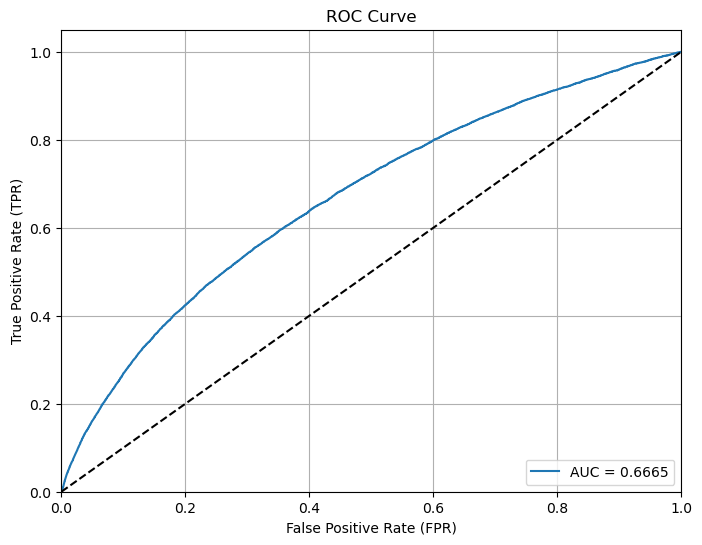

In [46]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()